In [ ]:
# default_exp cluster_ions

# Helper Functions

In [ ]:
#export
import scipy.spatial.distance as distance
import scipy.cluster.hierarchy as hierarchy

def find_fold_change_clusters(typenode, diffions, normed_c1, normed_c2, ion2diffDist, p2z, deedpair2doublediffdist, pval_threshold_basis, fcfc_threshold, take_median_ion):
    """Compares the fold changes of the ions corresponding to the nodes that are compared and returns the set of ions with consistent fold changes.

    Args:
        diffions (list[list[ionnames]]): contains the sets of ions to be tested, for example [[fragion1_precursor1, fragion2_precursor1, fragion3_precursor1],[fragion1_precursor2],[fragion1_precursor3, fragion2_precursor3]]. The ions are assumed to be similar in type (e.g. fragment, precursor)!
        normed_c1 (ConditionBackground): [description]
        normed_c2 (ConditionBackground): [description]
        ion2diffDist (dict(ion : SubtractedBackground)): [description]
        p2z ([type]): [description]
        deedpair2doublediffdist ([type]): [description]
        fc_threshold (float, optional): [description]. Defaults to 0.3.
        pval_threshold_basis (float, optional): [description]. Defaults to 0.05.
    """

    if len(diffions)==1:
        typenode.num_clusters = 1
        typenode.num_mainclusts = 1
        typenode.frac_mainclust = 1
        return [(typenode.children[0], 0)]

    diffions_idxs = [[x] for x in range(len(diffions))]
    diffions_fcs = get_fcs_ions(diffions)
    #mt_corrected_pval_thresh = pval_threshold_basis/len(diffions)
    condensed_distance_matrix = distance.pdist(diffions_idxs, lambda idx1, idx2: evaluate_distance(idx1[0], idx2[0], diffions, diffions_fcs, normed_c1, normed_c2, ion2diffDist,p2z,deedpair2doublediffdist, pval_threshold_basis, fcfc_threshold, take_median_ion))
    after_clust = hierarchy.complete(condensed_distance_matrix)
    clustered = hierarchy.fcluster(after_clust, 0.1, criterion='distance')
    clustered = exchange_cluster_idxs(clustered)
    typenode.num_clusters = len(set(clustered))
    typenode.num_mainclusts = sum([x==0 for x in clustered])
    typenode.frac_mainclust = typenode.num_mainclusts/len(clustered)
    
    childnode2clust = [(typenode.children[ion_idx],clust_idx) for ion_idx, clust_idx in zip(list(range(len(clustered))),clustered)]
    childnode2clust = sorted(childnode2clust, key = lambda x : x[0].name) #sort list for reproducibility

    return childnode2clust

In [ ]:
#export
def exchange_cluster_idxs(fclust_output_array):
    """The fcluster output assigns cluster numbers to the clustered elems, e.g. [1,2,1,2,2,2].
    This function here ensures that the numbers follow size of the cluster, e.g. [1,0,1,0,0,0]"""
    clustnum2count = {}
    for clustnum in fclust_output_array:
        clustnum2count[clustnum] = clustnum2count.get(clustnum, 0)+1
    clustnums = list(clustnum2count.keys())
    clustnums.sort(key = lambda x : clustnum2count.get(x), reverse= True)
    clustnum_old2clustnum_new = {clustnums[idx]: idx for idx in range(len(clustnums))}
    return [clustnum_old2clustnum_new.get(clustnum) for clustnum in fclust_output_array]

In [ ]:
#hide§

def test_exchange_cluster_idxs():
    assert exchange_cluster_idxs([1,2,1,2,2,2]) == [1,0,1,0,0,0]

In [ ]:
#export
def decide_cluster_order(node, childnode2clust_init):
    """ranks the clusters from 0 to n (with 0 being the best) depending on the properties/similarities of the child nodes contained in each cluster
    """
    childnode2clust = order_by_score(childnode2clust_init,node, score_mapping_function=get_score_mapping_consistency_score)

    return childnode2clust

def get_score_mapping_consistency_score(childnode2clust):
    clust2score = {}
    clust2childnodes = {}
    for childnode,clust in childnode2clust:
        clust2score[clust] = clust2score.get(clust, 0) + childnode.fraction_consistent*len(childnode.leaves)
        clust2childnodes[clust] = clust2childnodes.get(clust, []) + [childnode]
    return clust2score, clust2childnodes

def get_score_mapping_num_clustelems(childnode2clust):
    clust2score = {}
    clust2childnodes = {}
    for childnode,clust in childnode2clust:
        clust2score[clust] = clust2score.get(clust, 0) +1
        clust2childnodes[clust] = clust2childnodes.get(clust, []) + [childnode]
    return clust2score, clust2childnodes

def reformat_to_childnode2clust(id2score2childnodes):
    childnode2clust = {}
    for clust_idx_new in range(len(id2score2childnodes)): #the new cluster has been determined by the sorting
        for childnode in id2score2childnodes[clust_idx_new][2]:
            childnode2clust[childnode] = clust_idx_new
    return childnode2clust

def order_by_score(childnode2clust_init, node, score_mapping_function, sort_descending_by_score = True):
    clust2score, clust2childnodes = score_mapping_function(childnode2clust_init)

    id2score2childnodes = []
    for clust in clust2score.keys():
        score = clust2score.get(clust)
        childnodes = clust2childnodes.get(clust)
        id = childnodes[0].name
        id2score2childnodes.append((id, score, childnodes))
    
    id2score2childnodes = sorted(id2score2childnodes, key= lambda x : x[0])#sort by id (to ensure reproducibility)
    id2score2childnodes = sorted(id2score2childnodes, key= lambda x : x[1], reverse= sort_descending_by_score)#then sort by score
    node.clustscore = id2score2childnodes[0][1] #annotate the parent of the childnodes with the score of the main cluster
    childnode2clust = reformat_to_childnode2clust(id2score2childnodes)
    
    return childnode2clust


In [ ]:
#export
import numpy as np
def get_fcs_ions(diffions):
    fcs = np.ones(len(diffions))
    for idx in range(len(diffions)):
        fc_ions = np.nanmedian([ion.fc for ion in diffions[idx]])
        fcs[idx] = fc_ions
    return fcs

In [ ]:
#export
import statistics
import alphaquant.doublediff_analysis as aqdd
import numpy as np
def evaluate_distance(idx1, idx2, diffions, fcs, normed_c1, normed_c2, ion2diffDist, p2z, deedpair2doublediffdist, pval_threshold_basis, fcfc_threshold,  take_median_ion):
    ions1 = [x.name for x in diffions[idx1]]
    ions2 = [x.name for x in diffions[idx2]]
    fc1 = fcs[idx1]
    fc2 = fcs[idx2]

    if abs((fc1-fc2)) < fcfc_threshold:
        return 0

    if take_median_ion:
        fcs_ions1 = [x.fc for x in diffions[idx1]]
        fcs_ions2 = [x.fc for x in diffions[idx2]]
        idx_ions1 = np.argsort(fcs_ions1)[len(fcs_ions1)//2]
        idx_ions2 = np.argsort(fcs_ions2)[len(fcs_ions2)//2]
        ions1 = [ions1[idx_ions1]]
        ions2 = [ions2[idx_ions2]]

    fcfc, pval = aqdd.calc_doublediff_score(ions1, ions2, normed_c1, normed_c2,ion2diffDist,p2z, deedpair2doublediffdist)
    if (pval<pval_threshold_basis) & (abs(fcfc) > fcfc_threshold):
        return 1
    else:
        return 0

# Group and cluster ions


In [ ]:
#export
import anytree
import re
def create_hierarchical_ion_grouping(regex_patterns, gene_name, diffions):
    #regex patterns sorted from bottom to top in the following way list(list(tuple(pattern, name))): first instance of list represents the level of the tree, second instance represents the different nodes available on this level (for example FRgIon, MS1 are on the same level)

    nodes = [anytree.Node(x.name, type = "base", cluster = -1, is_included = True) for x in diffions]

    for level in regex_patterns:
        name2node = {}
        for pattern2name in level:
            for node in nodes:
                if (re.match(pattern2name[0], node.name)):
                    m = re.match(pattern2name[0], node.name)
                    matching_name = m.group(1)
                    name2node[matching_name] = name2node.get(matching_name, anytree.Node(matching_name,  type = pattern2name[1], cluster = -1, is_included = True))
                    parent_node = name2node.get(matching_name)
                    node.parent = parent_node

        if len(name2node.keys())>0:
            nodes = list(name2node.values())

    root_node = anytree.Node(gene_name, type = "gene", cluster = -1, is_included = True)

    for node in nodes:
        node.parent = root_node

    return root_node

In [ ]:
#export

def get_ionlist(type_nodes, ionname2diffion, select_mainclust_ions):
    ionlist = []
    node2leafs = {}
    for node in type_nodes:
        leafs = get_leafs(node, ionname2diffion, select_mainclust_ions)
        if len(leafs)>0:
            ionlist.append(leafs)
            node2leafs[node] = leafs

    return ionlist, node2leafs

def get_leafs(node, ionname2diffion,select_mainclust_ions):
    """Returns all the leafs (i.e. ions) that belong to the node. With the option to only include those that were in the main cluster of the child nodes

    Args:
        node ([type]): [description]
        ionname2diffion ([type]): [description]
        select_mainclust_ions ([type]): [description]

    Returns:
        [type]: [description]
    """
    if node.is_leaf:
        return [ionname2diffion.get(node.name)]
    leafs = []
    for child in node.children:
        if select_mainclust_ions & (child.cluster!=0):
            continue
        leafs.extend([ionname2diffion.get(x.name) for x in child.leaves if x.is_included])
            
    return leafs



def update_nodes(type_node, typefilter, type_idx, childnode2clust):

    for node in type_node.children:
        if not node.is_included:
            continue
        clustid =  childnode2clust.get(node)
        node.cluster = clustid
        leafs_included = [x for x in type_node.leaves if x.is_included]
        no_leafs = len(leafs_included)==0
        wrong_cluster = (clustid!=typefilter.select_cluster[type_idx]) & (typefilter.select_cluster[type_idx] !=-1)
        #wrong_cluster = (clustid!=type_node.mostcommon_clust) & (typefilter.select_cluster[type_idx] ==-1) #all children should belong to the most common cluster

        if wrong_cluster | no_leafs:
            exclude_node(node)

    filtercrit_numclust = hasattr(type_node, "num_clusters") and (type_node.num_clusters > typefilter.exclude_if_more_clusters_than[type_idx])
    filtercrit_frac_mainclust = hasattr(type_node, "frac_mainclust") and (type_node.frac_mainclust < typefilter.exclude_if_fraction_of_mainclust_smaller_than[type_idx])
    filtercrit_elems_mainclust = hasattr(type_node, "num_mainclust_elems") and(type_node.num_mainclust_elems < typefilter.exclude_if_elements_in_mainclust_less_than[type_idx])
    filtercrit_elems_mostcommonclust = hasattr(type_node, "num_mostcommonclust_elems") and(type_node.num_mostcommonclust_elems < typefilter.exclude_if_elements_in_mostcommonclust_less_than[type_idx])
    filtercrit_frac_mostcommonclust = hasattr(type_node, "frac_mostcommonclust") and(type_node.frac_mostcommonclust < typefilter.exclude_if_frac_mostcommonclust_less_than[type_idx])
    filtercrit_num_mainclusts = hasattr(type_node, "num_mainclusts") and(type_node.num_mainclusts < typefilter.exclude_if_num_mainclusts_less_than[type_idx])
    filtercrit_num_mostcommonclusts = hasattr(type_node, "num_mostcommon_clusts") and(type_node.num_mostcommon_clusts < typefilter.exclude_if_num_mostcommonclusts_less_than[type_idx])
    no_leafs = len([x for x in node.leaves if x.is_included])==0
    #print("filtercrit_numclust\tfiltercrit_frac_mainclust\tfiltercrit_elems_mainclust\tfiltercrit_elems_mostcommonclust\tfiltercrit_frac_mostcommonclust\tfiltercrit_num_mainclusts\tfiltercrit_num_mostcommonclusts")
    #print(f"{filtercrit_numclust}\t{filtercrit_frac_mainclust}\t{filtercrit_elems_mainclust}\t{filtercrit_elems_mostcommonclust}\t{filtercrit_frac_mostcommonclust}\t{filtercrit_num_mainclusts}\t{filtercrit_num_mostcommonclusts}")

    if filtercrit_numclust | filtercrit_frac_mainclust | filtercrit_elems_mainclust |filtercrit_elems_mostcommonclust| filtercrit_frac_mostcommonclust |filtercrit_num_mainclusts | filtercrit_num_mostcommonclusts | no_leafs :
        exclude_node(type_node)

In [ ]:
#export

def exclude_node(node):
    node.is_included = False
    for descendant in node.descendants:
        descendant.is_included = False

In [ ]:
#export
import pickle
import pandas as pd
def cluster_along_specified_levels(typefilter, root_node, ionname2diffion, normed_c1, normed_c2, ion2diffDist, p2z, deedpair2doublediffdist, pval_threshold_basis, fcfc_threshold, take_median_ion):
    #typefilter object specifies filtering and clustering of the nodes
    assign_fcs_to_base_ions(root_node, ionname2diffion, normed_c1, normed_c2)
    
    for idx in range(len(typefilter.type)):
        type_nodes = anytree.search.findall(root_node, filter_=lambda node: node.type == typefilter.type[idx])

        if len(type_nodes)==0:
            continue
        for type_node in type_nodes:
            child_nodes = type_node.children
            #leaflist, node2leafs = get_ionlist(child_nodes, ionname2diffion, select_mainclust_ions=True)
            leaflist = get_mainclust_leaves(child_nodes, ionname2diffion)
            #print(type_node.name)
            #print([len([y.name for y in x]) for x in leaflist])
            if len(leaflist)==0:
                exclude_node(type_node)
                continue
            childnode2clust = find_fold_change_clusters(type_node,leaflist, normed_c1, normed_c2, ion2diffDist, p2z, deedpair2doublediffdist, pval_threshold_basis, fcfc_threshold, take_median_ion) #the clustering is performed on the child nodes
            childnode2clust = decide_cluster_order(type_node,childnode2clust)
            annotate_mainclust_leaves(childnode2clust)
            update_nodes(type_node, typefilter, idx, childnode2clust)
            assign_vals_to_node(type_node,only_use_mainclust=True, use_fewpeps_per_protein=True)
    
    return root_node

In [ ]:
#export

def get_mainclust_leaves(child_nodes, ionname2diffion):
    grouped_leafs = []
    for child in child_nodes:
        child_leaves_mainclust = []
        types_previous_level = {x.type for x in child.children}
        for leafnode in child.leaves:#go through the leafs of each child
            if hasattr(leafnode, 'inclusion_levels') and not (leafnode.inclusion_levels[-1] in types_previous_level):
                continue
            child_leaves_mainclust.append(leafnode)
        child_leafs_diffions = [ionname2diffion.get(x.name) for x in child_leaves_mainclust] #map the leaf names to the diffion objetcs
        if len(child_leafs_diffions)>0:
            grouped_leafs.append(child_leafs_diffions)
    return grouped_leafs



In [ ]:
#export
def annotate_mainclust_leaves(childnode2clust):
    #annotate each leaf that has reached the current level with the level name, allows to visualize how the leafs are propagated
    for child in childnode2clust.keys():
        if childnode2clust.get(child)!=0:
            continue
        types_previous_level = {x.type for x in child.children}
        for leafnode in child.leaves:#annotate the leaves of each node, if they were included at this level
            if hasattr(leafnode, 'inclusion_levels'):
                
                if leafnode.inclusion_levels[-1] in types_previous_level: #only add a level if the previous level has also been included
                    leafnode.inclusion_levels.append(child.type)
            else:
                leafnode.inclusion_levels = [child.type]

In [ ]:
#export
import anytree
import alphaquant.diff_analysis as aqdiff
import alphaquant.diffquant_utils as aqutils
from scipy.stats import norm
import statistics
import numpy as np

def assign_vals_to_node(node, only_use_mainclust, use_fewpeps_per_protein):
    """Goes through the children and summarizes their properties to the node

    Args:
        node ([type]): [description]
        only_use_mainclust (bool, optional): [description]. Defaults to True.
    """

    if only_use_mainclust:
        childs = [x for x in node.children if x.is_included & (x.cluster ==0)]
    else:
        childs = [x for x in node.children if x.is_included]

    if use_fewpeps_per_protein and node.type == "gene":
        childs = filter_fewpeps_per_protein(childs)

 
    zvals = [x.z_val for x in childs]
    fcs =  [x.fc for x in childs]
    cvs = [x.cv for x in childs]
    min_intensity = np.nanmedian([x.min_intensity for x in childs])
    min_reps = np.nanmedian([x.min_reps for x in childs])
    fraction_consistent = sum([x.fraction_consistent/len(node.children) for x in childs if x.cluster ==0])



    z_sum = sum(zvals)
    p_z = norm(0, np.sqrt(len(zvals))).cdf(z_sum)
    z_normed = norm.ppf(p_z)
    if z_normed <-8.2:
        z_normed = -8.2
    if z_normed > 8.2:
        z_normed = 8.2

    p_val = max(1e-16, 2.0 * (1.0 - norm(0, np.sqrt(len(zvals))).cdf(abs(z_sum))))

    node.z_val = z_normed
    node.p_val = p_val
    node.fc = np.nanmedian(fcs)
    node.fraction_consistent = fraction_consistent
    node.cv = min(cvs)
    node.min_intensity = min_intensity
    node.min_reps = min_reps

    if hasattr(node.children[0], 'predscore'):
        predscores = [x.predscore for x in childs]
        node.predscore = np.nanmedian(predscores)
        node.cutoff = childs[0].cutoff
        node.ml_excluded = abs(node.predscore)< node.cutoff

def filter_fewpeps_per_protein(peptide_nodes):
    peps_filtered = []
    pepnode2pval2numleaves = []
    for pepnode in peptide_nodes:
        pepleaves = [x for x in pepnode.leaves if "seq" in x.inclusion_levels]
        pepnode2pval2numleaves.append((pepnode, pepnode.p_val,len(pepleaves)))
    pepnode2pval2numleaves = sorted(pepnode2pval2numleaves, key=lambda x : x[1], reverse=True)
    numleaves_total = 0
    for pepnode, _, numleaves in pepnode2pval2numleaves:
        peps_filtered.append(pepnode)
        numleaves_total+=numleaves
        if numleaves_total>4:
            break
    return peps_filtered



def get_diffresults_from_clust_root_node(root_node):
    pval = root_node.p_val
    fc = root_node.fc
    ions_included = [x.name for x in root_node.leaves if x.is_included]
    consistency_score = root_node.fraction_consistent * len(root_node.leaves)
    return pval, fc, consistency_score, ions_included

def get_scored_clusterselected_ions(gene_name, diffions, normed_c1, normed_c2, ion2diffDist, p2z, deedpair2doublediffdist, pval_threshold_basis, fcfc_threshold, take_median_ion):
    #typefilter = TypeFilter('successive')
    typefilter = init_typefilter_from_yaml('default')
    regex_patterns = regex_frgions_isotopes
    name2diffion = {x.name : x for x in diffions}
    root_node = create_hierarchical_ion_grouping(regex_patterns, gene_name, diffions)
    #print(anytree.RenderTree(root_node))
    root_node_clust = cluster_along_specified_levels(typefilter, root_node, name2diffion, normed_c1, normed_c2, ion2diffDist, p2z, deedpair2doublediffdist, pval_threshold_basis, fcfc_threshold, take_median_ion)
    #print(anytree.RenderTree(root_node_clust))
    level_sorted_nodes = [[node for node in children] for children in anytree.ZigZagGroupIter(root_node_clust)]
    level_sorted_nodes.reverse() #the base nodes are first

    # for idx in range(0, len(level_sorted_nodes)):
    #     nodes = level_sorted_nodes[idx]
    #     if idx==0:
    #         assign_fcs_to_base_ions(nodes, name2diffion)
    #         continue
    #     for node in nodes:
    #         if not node.is_included:
    #             continue
    #         assign_vals_to_node(node, idx, name2diffion)
    root_node_lvl = level_sorted_nodes[-1]
    if len(root_node_lvl)!=1:
        Exception("there should be only one root node!")

    root_node_annot =root_node_lvl[0]
    return root_node_annot

import scipy.stats
def assign_fcs_to_base_ions(root_node, name2diffion, normed_c1, normed_c2):
    for leaf in root_node.leaves:
        leaf.fc = name2diffion.get(leaf.name).fc
        leaf.z_val = name2diffion.get(leaf.name).z_val
        leaf.fraction_consistent = 1
        original_intensities_c1 = 2**(normed_c1.ion2nonNanvals.get(leaf.name))
        original_intensities_c2 = 2**(normed_c2.ion2nonNanvals.get(leaf.name))
        cv_c1 = scipy.stats.variation(original_intensities_c1)
        cv_c2 = scipy.stats.variation(original_intensities_c2)
        leaf.cv = min(cv_c1, cv_c2)
        leaf.min_intensity = min(sum(original_intensities_c1)/len(original_intensities_c1), sum(original_intensities_c2)/len(original_intensities_c2))
        leaf.min_reps = min(len(normed_c1.ion2nonNanvals.get(leaf.name)), len(normed_c2.ion2nonNanvals.get(leaf.name)) )

## Integrate ML scores

In [ ]:
#export

def update_nodes_w_ml_score(protnodes):
    typefilter = init_typefilter_from_yaml('default')
    for prot in protnodes:
        re_order_depending_on_predscore(prot, typefilter)


def re_order_depending_on_predscore(protnode, typefilter):
    for idx in range(len(typefilter.type)):
        type_nodes = anytree.search.findall(protnode, filter_=lambda node: node.type == typefilter.type[idx])
        if len(type_nodes)==0:
            continue
        for type_node in type_nodes: #go through the nodes, re-order the children. Propagate the values from the newly ordered children to the type node
            child_nodes = type_node.children
            had_predscore = hasattr(child_nodes[0], 'predscore')
            if had_predscore:
                re_order_clusters_by_predscore(child_nodes)
                assign_vals_to_node(type_node)



def re_order_clusters_by_predscore(nodes):
    cluster2scores = {}
    for node in nodes:
        cluster2scores[node.cluster] = cluster2scores.get(node.cluster, [])
        cluster2scores[node.cluster].append(node.predscore)
    clusters = list(cluster2scores.keys())
    clusters.sort(key = lambda x : abs(np.nanmedian(cluster2scores.get(x))))
    clust2newclust = { clusters[x] :x for x in range(len(clusters))}
    for node in nodes:
        node.cluster =clust2newclust.get(node.cluster)

## Configs

In [ ]:
#export
import numpy as np
class TypeFilter():
    def __init__(self, filttype= 'hierarchy'):
        if filttype=='hierarchy':
            self.type = ['frgion', 'ms1_isotopes', 'mod_seq_charge', 'mod_seq', 'seq', 'gene']
            self.select_cluster = [-1,-1,-1,-1,-1,-1,-1]
            self.exclude_if_more_clusters_than = [ np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]
            self.exclude_if_fraction_of_mainclust_smaller_than = [0, 0, 0, 0, 0, 0]
            self.exclude_if_frac_mostcommonclust_less_than = [0,0,0,0,0,0]
            self.exclude_if_elements_in_mainclust_less_than = [0, 0, 0, 0, 0, 0]
            self.exclude_if_elements_in_mostcommonclust_less_than = [0, 0, 0, 0, 0, 0]
            self.exclude_if_num_mainclusts_less_than = [0, 0, 0, 0, 0, 0]
            self.exclude_if_num_mostcommonclusts_less_than = [0, 0, 0, 0, 0, 2]
        if filttype == 'only_frgion':
            self.type = ['frgion', 'ms1_isotopes', 'mod_seq_charge', 'mod_seq', 'seq', 'gene']
            self.select_cluster = [0,-1,-1,-1,-1,-1,-1]
            self.exclude_if_more_clusters_than = [ np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]
            self.exclude_if_fraction_of_mainclust_smaller_than = [0, 0, 0.2, 0, 0, 0.3]
            self.exclude_if_frac_mostcommonclust_less_than = [0,0,0,0,0,0]
            self.exclude_if_elements_in_mainclust_less_than = [1, 1, 1, 1, 1, 1]
            self.exclude_if_elements_in_mostcommonclust_less_than = [1, 1, 1, 1, 1, 1]
            self.exclude_if_num_mainclusts_less_than = [1, 1, 1, 1, 1, 1]
            self.exclude_if_num_mostcommonclusts_less_than = [1, 1, 1, 1, 1, 2]
        if filttype=='successive':
            self.type = ['frgion', 'ms1_isotopes', 'mod_seq_charge', 'mod_seq', 'seq', 'gene']
            self.select_cluster = [0, 0,-1,-1,-1,-1,-1]
            self.exclude_if_more_clusters_than = [ np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]
            self.exclude_if_fraction_of_mainclust_smaller_than = [0, 0, 0.6, 0.6, 0, 0]
            self.exclude_if_frac_mostcommonclust_less_than = [0,0,0,0,0,0]
            self.exclude_if_elements_in_mainclust_less_than = [0, 0, 0, 0, 0, 0]
            self.exclude_if_elements_in_mostcommonclust_less_than = [0, 0, 0, 0, 0, 0]
            self.exclude_if_num_mainclusts_less_than = [0, 0, 2, 0, 0, 2]
            self.exclude_if_num_mostcommonclusts_less_than = [0, 0, 0, 0, 0, 0]

In [ ]:
#export
import yaml
import os
import pathlib
def init_typefilter_from_yaml(filttype):
    typefilter_yaml = os.path.join(pathlib.Path(__file__).parent.absolute(), "..", "typefilt_config.yaml")
    stream = open(typefilter_yaml, 'r')
    typefilter_yaml = yaml.safe_load(stream)
    filttype_dict = typefilter_yaml.get(filttype)
    typefilt = TypeFilter(filttype)
    typefilt.type = filttype_dict.get("type")
    typefilt.select_cluster = filttype_dict.get("select_cluster")
    typefilt.exclude_if_more_clusters_than = filttype_dict.get("exclude_if_more_clusters_than")
    typefilt.exclude_if_fraction_of_mainclust_smaller_than = filttype_dict.get("exclude_if_fraction_of_mainclust_smaller_than")
    typefilt.exclude_if_frac_mostcommonclust_less_than = filttype_dict.get("exclude_if_frac_mostcommonclust_less_than")
    typefilt.exclude_if_num_mainclusts_less_than = filttype_dict.get("exclude_if_num_mainclusts_less_than")
    typefilt.exclude_if_num_mostcommonclusts_less_than = filttype_dict.get("exclude_if_num_mostcommonclusts_less_than")

    return typefilt

In [ ]:
#export

import numpy as np
class NodeProperties():
    """Helper class to handle node properties"""
    def __init__(self):
        self.num_clusters = None
        self.num_mainclust_elems = None
        self.num_mostcommonclust_elems = None
        self.frac_mainclust = None
        self.frac_mostcommonclust = None
        self.num_mainclusts = None
        self.num_mostcommon_clusts = None
        self.mostcommon_clust = None

In [ ]:
#export

regex_frgions_only = [[("(SEQ.*MOD.*CHARGE.*FRGION.*)", "frgion")], [("(SEQ.*MOD.*CHARGE.*)(FRGION.*)", "mod_seq_charge")], [("(SEQ.*MOD.*)(CHARGE.*)", "mod_seq")], [("(SEQ.*)(MOD.*)", "seq")]]

regex_frgions_isotopes = [[("(SEQ.*MOD.*CHARGE.*FRG)(ION.*)", "frgion"), ("(SEQ.*MOD.*CHARGE.*MS1)(ISO.*)", "ms1_isotopes")], [("(SEQ.*MOD.*CHARGE.*)(FRG.*|MS1.*)", "mod_seq_charge")], [("(SEQ.*MOD.*)(CHARGE.*)", "mod_seq")], [("(SEQ.*)(MOD.*)", "seq")]]

## Export/Import

In [ ]:
#export

import anytree
from anytree.exporter import JsonExporter
import alphaquant.diffquant_utils as aqutils

def export_roots_to_json(rootlist, condpair, results_dir):
    """exports all base roots for a given condition pair to a json file"""
    condpairname = aqutils.get_condpairname(condpair)
    condpair_node = anytree.Node(condpair) #set the condpair as node and export the whole condpair as one tree
    for root in rootlist:
        root.parent = condpair_node
    results_file = f"{results_dir}/{condpairname}.iontrees.json"

    j_exporter = JsonExporter(indent=2, sort_keys=True)
    filehandle = open(results_file, "w")
    j_exporter.write(condpair_node, filehandle)
    filehandle.close()

In [ ]:
# #export
# from collections import Counter
# def propagate_clusters(diffions, ion2cluster):
#     """
#     Gives basic cluster statistics for sets of ions corresponding to a node
#      Args:
#         diffions (list[list[ionnames]] ): contains the sets of ions to be tested, for examples [[fragion1_precursor1, fragion2_precursor1, fragion3_precursor1],[fragion1_precursor2],[fragion1_precursor3, fragion2_precursor3]]. The ions are assumed to be similar!
#         ion2cluster: given assignment of base ion to cluster
#     """

#     num_mainclust_elems = 0
#     num_mostcommonclust_elems = 0
#     ions2clust = {}
#     all_clusters = []
#     for ions in diffions:
#         clusters = []
#         for ion in ions:
#             clusters.append(ion2cluster.get(ion))
#         c = Counter(clusters).most_common(1)
#         cluster = c[0][0]
#         ions2clust[tuple(ions)] = cluster
#         num_mainclust_elems += clusters.count(0)
#         num_mostcommonclust_elems += clusters.count(cluster)
#         all_clusters.append(cluster)
#     c_mostcommon = Counter(all_clusters).most_common(1)
#     clust_mostcommon = c_mostcommon[0][0]
#     num_mostcommon_clusts = all_clusters.count(clust_mostcommon)
#     num_mainclusts = all_clusters.count(0)
#     frac_mainclust = num_mainclusts/len(all_clusters)
#     frac_mostcommonclust =  num_mostcommon_clusts/len(all_clusters)
#     num_clusters = len(set(all_clusters))
    
#     nodeprops = NodeProperties()
#     nodeprops.num_clusters = num_clusters
#     nodeprops.num_mainclust_elems = num_mainclust_elems #elements in the overall biggest cluster
#     nodeprops.num_mostcommonclust_elems = num_mostcommonclust_elems #elements in the most common cluster for this particular node. 
#     #The most common cluster can only be different from the main cluster in case that clustering has been carried out outside of the set
#     nodeprops.frac_mainclust = frac_mainclust
#     nodeprops.frac_mostcommonclust = frac_mostcommonclust
#     nodeprops.num_mainclusts = num_mainclusts
#     nodeprops.num_mostcommon_clusts = num_mostcommon_clusts
#     nodeprops.mostcommon_clust = clust_mostcommon

#     return ions2clust,nodeprops

        


# Test Clustering

In [ ]:
import uuid
import alphaquant.background_distributions as aqbg
import alphaquant.benchmarking as aqbm
import alphaquant.diff_analysis as aqdiff
import alphaquant.diffquant_utils as aqutils
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def simulate_normed_input():

    sample2cond_df = pd.DataFrame({'sample' : ['A1', 'A2', 'A3', 'B1', 'B2', 'B3','B4', 'B5', 'B6', 'B7', 'B8', 'B9','B10', 'B11', 'B12'],
    'condition' : ['A', 'A', 'A', 'B', 'B', 'B','B', 'B', 'B','B', 'B', 'B','B', 'B', 'B']})
    unnormed_df = aqbm.generate_random_input(10000, sample2cond_df,simulate_nas=True)
    df_c1, df_c2 = get_c1_c2_dfs(unnormed_df, sample2cond_df, ["A", "B"])
    p2z = {}
    normed_c1 = aqbg.ConditionBackgrounds(df_c1, p2z)
    normed_c2 = aqbg.ConditionBackgrounds(df_c2, p2z)
    return normed_c1, normed_c2

def get_c1_c2_dfs(unnormed_df, labelmap_df, condpair, minrep = 2):
    c1_samples = labelmap_df[labelmap_df["condition"]== condpair[0]]
    c2_samples = labelmap_df[labelmap_df["condition"]== condpair[1]]
    df_c1 = unnormed_df.loc[:, c1_samples["sample"]].dropna(thresh=minrep, axis=0)
    df_c2 = unnormed_df.loc[:, c2_samples["sample"]].dropna(thresh=minrep, axis=0)

    return df_c1, df_c2

def generate_diffions():
    normed_c1, normed_c2 = simulate_normed_input()
    ion2diffDist = {}
    p2z = {}
    diffions = []
    ions_to_check = normed_c1.ion2nonNanvals.keys() & normed_c2.ion2nonNanvals.keys()
    for idx, ion in enumerate(ions_to_check):
        if not (("pep12_" in ion) | ("pep23_" in ion)):
            continue

        vals1 = normed_c1.ion2nonNanvals.get(ion)
        vals2 = normed_c2.ion2nonNanvals.get(ion)
        diffDist = aqbg.get_subtracted_bg(ion2diffDist,normed_c1, normed_c2,ion, p2z)
        diffIon = aqdiff.DifferentialIon(vals1, vals2, diffDist, ion, outlier_correction = False)
        diffions.append(diffIon)
        #if idx>100:
         #   break
    
    return diffions, normed_c1, normed_c2


def add_shifts_to_diffions(ion2shift,diffions, normed_c1, normed_c2):
    ion2diffdist = {}
    ionname2diffion = {}
    for ion in diffions:
        shift = ion2shift.get(ion.name)
        vals1 = normed_c1.ion2nonNanvals.get(ion.name)
        vals2 = normed_c2.ion2nonNanvals.get(ion.name)
        ion.fc = ion.fc+shift
        if shift>0:
            vals2 = vals2+shift
            normed_c2.ion2nonNanvals[ion.name] = vals2
            normed_c2.ion2allvals[ion.name] = np.array([x + shift for x in  normed_c2.ion2allvals[ion.name] if x!=0])
            
        if shift<0:
            vals1 = vals1+shift
            normed_c1.ion2nonNanvals[ion.name] = vals1
            normed_c1.ion2allvals[ion.name] =  np.array([x + shift for x in  normed_c1.ion2allvals[ion.name] if x!=0])
        diffDist = aqbg.get_subtracted_bg(ion2diffdist,normed_c1, normed_c2,ion.name, {})

        diffIon = aqdiff.DifferentialIon(vals1, vals2, diffDist, ion.name, outlier_correction = False)
        ionname2diffion[ion.name] = diffIon
        #if idx>100:
         #   break

    return ionname2diffion
    


import alphaquant.benchmarking as aqbench
import alphaquant.diffquant_utils as aqutils

def test_tree_construction():

    diffions, normed_c1, normed_c2 = generate_diffions()
    regex_patterns = [[("(.*_LVL0.*_LVL1.*_LVL2.*_LVL3)(_mod[0-1])","frgion"), ("(.*_LVL0.*_LVL1.*_LVL2.*_LVL3)(_mod[2-3])", "ms1_isotopes")], [("(.*_LVL0.*_LVL1.*_LVL2)(.*_LVL3)", "mod_seq_charge")], [("(.*_LVL0.*_LVL1)(.*_LVL2)", "mod_seq")], 
    [("(.*)(.*_LVL0.*_LVL1.*)", "seq")]]
    node = create_hierarchical_ion_grouping(regex_patterns,"testgene",diffions)
    #print(anytree.RenderTree(node))
    #dotexporter.UniqueDotExporter(node).to_picture("tmp.png")
    print(f'diffions {[x.name for x in diffions]}')
    typefilter = TypeFilter()

    deedpair2doublediffdist = {}
    dpair2diffdist = {}
    p2z = {}
    aqbench.add_perturbations_to_proteins([node])
    ion2shift = {x.name:x.applied_shift for x in node.leaves}
    ionname2diffion = add_shifts_to_diffions(ion2shift, diffions, normed_c1, normed_c2)
    node_clust = cluster_along_specified_levels(typefilter,node,ionname2diffion, normed_c1, normed_c2,dpair2diffdist,p2z, deedpair2doublediffdist, pval_threshold_basis=0.05, fcfc_threshold=0, take_median_ion=False)
    aqbench.count_correctly_excluded([node], [node])
    #logging.info(anytree.RenderTree(node_clust))
    #print(anytree.RenderTree(node_clust))



test_tree_construction()


4726
t_ion2nonan_sw 0.011356115341186523
t_intensity_selection 0.39522719383239746
t_ion2nonan_sw 0.009817838668823242
t_intensity_selection 1.9364638328552246
diffions ['pep23_LVL0_mod0_LVL1_mod0_LVL2_mod0_LVL3_mod0', 'pep12_LVL0_mod0_LVL1_mod0_LVL2_mod0_LVL3_mod1', 'pep12_LVL0_mod0_LVL1_mod0_LVL2_mod0_LVL3_mod0', 'pep23_LVL0_mod0_LVL1_mod1_LVL2_mod0_LVL3_mod0']


normalized within conditions
median 0.00729314330089359, mode 0.0009959526163560994
using median for shift
shift cond 2 by -0.00729314330089359
t_ion2nonan_sw 0.04566192626953125
t_intensity_selection 1.5283470153808594
t_ion2nonan_sw 0.046247243881225586
t_intensity_selection 1.4687960147857666


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


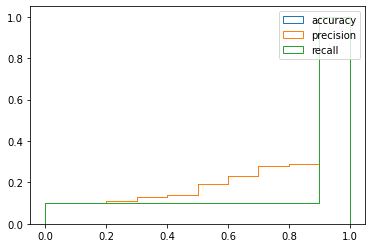

In [ ]:
import anytree
import sklearn.metrics
import random


def select_shifts_for_ions(diffions):
    ion2shift = {}
    for diffion in diffions:
        perturb = np.random.uniform(0, 1) < 0.3 #randomly select ~30% of the samples for perturbation
        if perturb:
            applied_shift = random.sample([-2, 2],1)[0]
            ion2shift[diffion.name] = applied_shift
        else:
            ion2shift[diffion.name] = 0
    return ion2shift

def compare_clustered_and_shifted(ion2shift, ion2clust):
    is_shifted_vec = []
    clust_nonzero_vec = []
    for ion in ion2shift:
        is_shifted = ion2shift.get(ion)!=0
        clust_nonzero = ion2clust.get(ion)!=0
        if (not is_shifted) and (not clust_nonzero):
            continue
        clust_nonzero_vec.append(clust_nonzero)
        is_shifted_vec.append(is_shifted)
    
    
    accuracy = sklearn.metrics.accuracy_score(y_true = is_shifted_vec, y_pred = clust_nonzero_vec)
    recall = sklearn.metrics.recall_score(y_true=is_shifted_vec, y_pred = clust_nonzero_vec)
    precision = sklearn.metrics.precision_score(y_true=is_shifted_vec, y_pred = clust_nonzero_vec)
    length = len(clust_nonzero_vec)
    #print(f"accuracy is {accuracy}")
    #print(f"precision {precision}\trecall {recall}")

    return accuracy, precision, recall, length



def check_correct_clustering(diffions, normed_c1, normed_c2):
    diffions_grouped = [[x] for x in diffions]
    ion2shift = select_shifts_for_ions(diffions)
    ionname2diffion = add_shifts_to_diffions(ion2shift, diffions, normed_c1, normed_c2)
    type_node = anytree.Node("root")
    for diffion in ionname2diffion.values():
        anytree.Node(diffion.name, parent=type_node)
    childnode2clust = find_fold_change_clusters(type_node, diffions_grouped, normed_c1, normed_c2, {}, {}, {},0.05, 0,False) #the clustering is performed on the child nodes
    chilnodename2clust = {x.name : y for x,y in childnode2clust}
    return compare_clustered_and_shifted(ion2shift, chilnodename2clust)


diffions_real, normed_c1_real, normed_c2_real = aqbench.load_real_example_ions("test_data/cluster_ions/filtered_fragions.aq_reformat.tsv",
"test_data/cluster_ions/samples.map.tsv",num_ions=1000)

diffions_subsetted = [diffions_real[i:i + 10] for i in range(0, len(diffions_real), 10)]
accuracies = []
precisions = []
recalls = []
for diffions in diffions_subsetted:
    accuracy,precison,recall, length = check_correct_clustering(diffions, normed_c1_real, normed_c2_real)
    accuracies.append(accuracy)
    precisions.append(precison)
    recalls.append(recall)

plt.hist(accuracies, cumulative=True, density=True, histtype='step', label='accuracy')
plt.hist(precisions,cumulative=True, density=True, histtype='step', label='precision')
plt.hist(recalls,cumulative=True, density=True, histtype='step', label='recall')
plt.legend()
plt.show()

#diffions_simul, normed_c1_simul, normed_c2_simul =generate_diffions()
#check_correct_clustering(diffions_simul, normed_c1_simul, normed_c2_simul)
